Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import math
from IPython.display import clear_output

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  dedup_valid_dataset = save['dedup_valid_dataset']
  dedup_valid_labels = save['dedup_valid_labels']
  dedup_test_dataset = save['dedup_test_dataset']
  dedup_test_labels = save['dedup_test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)
  print('Deduplicated validation set', dedup_valid_dataset.shape, dedup_valid_labels.shape)
  print('Deduplicated test set', dedup_test_dataset.shape, dedup_test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)
Deduplicated validation set (8093, 28, 28) (8093,)
Deduplicated test set (7741, 28, 28) (7741,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
orig_valid_dataset, orig_valid_labels = reformat(valid_dataset, valid_labels)
orig_test_dataset, orig_test_labels = reformat(test_dataset, test_labels)
dedup_valid_dataset, dedup_valid_labels = reformat(dedup_valid_dataset, dedup_valid_labels)
dedup_test_dataset, dedup_test_labels = reformat(dedup_test_dataset, dedup_test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', orig_valid_dataset.shape, orig_valid_labels.shape)
print('Test set', orig_test_dataset.shape, orig_test_labels.shape)
print('Deduplicated validation set', dedup_valid_dataset.shape, dedup_valid_labels.shape)
print('Deduplicated test set', dedup_test_dataset.shape, dedup_test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)
Deduplicated validation set (8093, 28, 28, 1) (8093, 10)
Deduplicated test set (7741, 28, 28, 1) (7741, 10)


In [4]:
valid_dataset = dedup_valid_dataset
valid_labels = dedup_valid_labels
test_dataset = dedup_test_dataset
test_labels = dedup_test_labels

In [5]:
valid_dataset = orig_valid_dataset
valid_labels = orig_valid_labels
test_dataset = orig_test_dataset
test_labels = orig_test_labels

In [6]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.equal(np.argmax(predictions, 1), np.argmax(labels, 1)))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [14]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [15]:
%%time

num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 5.451924
Minibatch accuracy: 6.2%
Validation accuracy: 11.0%
Minibatch loss at step 50: 1.837906
Minibatch accuracy: 37.5%
Validation accuracy: 45.0%
Minibatch loss at step 100: 1.260948
Minibatch accuracy: 62.5%
Validation accuracy: 63.5%
Minibatch loss at step 150: 0.389143
Minibatch accuracy: 81.2%
Validation accuracy: 74.1%
Minibatch loss at step 200: 0.951955
Minibatch accuracy: 75.0%
Validation accuracy: 76.3%
Minibatch loss at step 250: 1.175404
Minibatch accuracy: 62.5%
Validation accuracy: 76.0%
Minibatch loss at step 300: 0.264862
Minibatch accuracy: 93.8%
Validation accuracy: 78.6%
Minibatch loss at step 350: 0.614283
Minibatch accuracy: 93.8%
Validation accuracy: 75.5%
Minibatch loss at step 400: 0.323176
Minibatch accuracy: 93.8%
Validation accuracy: 79.5%
Minibatch loss at step 450: 0.904079
Minibatch accuracy: 75.0%
Validation accuracy: 78.5%
Minibatch loss at step 500: 0.843628
Minibatch accuracy: 87.5%
Validation accuracy: 80.1%
Mi

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [8]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    pool = tf.nn.max_pool(conv, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    pool = tf.nn.max_pool(conv, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

Minibatch loss at step 125000: 0.465101
Minibatch accuracy: 75.0%
Validation accuracy: 89.0%
[1 9 3 8 9 3 9 7 0 7 3 4 9 2 4 2 4 2 7 1 1 4 8 0 1 7 8 2 9 8 9 3 4 6 3]


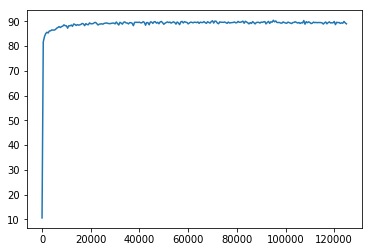

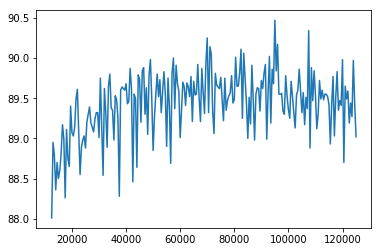

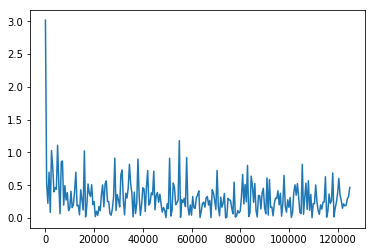

Test accuracy: 95.0%


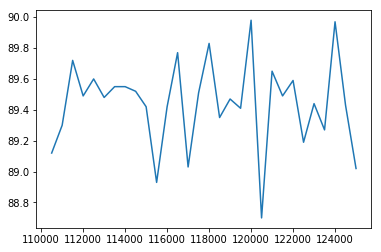

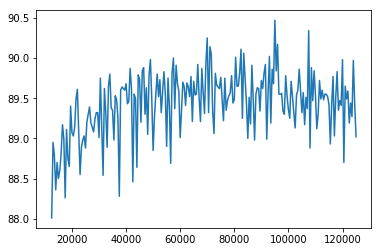

In [9]:
num_steps = 125001
disp_inc = 500

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  track_progress = []
  track_loss = []
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % disp_inc == 0):
      val_pred = valid_prediction.eval()
      valid_acc = accuracy(val_pred, valid_labels)
      track_progress.append(valid_acc)
      track_loss.append(l)
        
      clear_output(wait=True)
    
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % valid_acc)
      print(np.argmax(val_pred[0:35], 1))
      
      plt.plot([disp_inc * i for i in range(len(track_progress))], track_progress)
      plt.show()
      drop_some = track_progress[(len(track_progress) + 5) // 10:]
      plt.plot([disp_inc * i for i in range(len(track_progress) - len(drop_some), len(track_progress))], drop_some)
      plt.show()
      plt.plot([disp_inc * i for i in range(len(track_loss))], track_loss)
      plt.show()

  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
  last_bit = track_progress[-30:]
  plt.plot([disp_inc * i for i in range(len(track_progress) - len(last_bit), len(track_progress))], last_bit)
  plt.show()
  last_bit = track_progress[(len(track_progress) + 5) // 10:]
  plt.plot([disp_inc * i for i in range(len(track_progress) - len(last_bit), len(track_progress))], last_bit)
  plt.show()

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [225]:
batch_size = 16
patch_size = 5
depths = [8, 16, 32]
num_hidden = [240, 60]
loss_coeff = 0.03
keep_prob = 0.6

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  def activate(activations, training):
    res = tf.nn.relu(activations)
    if training:
      res = tf.nn.dropout(res, keep_prob)
    return res

  def xavier(shape):
    stddev =  math.sqrt(2.0 / np.prod(shape[:len(shape) - 1]))
    print(stddev)
    return stddev

  def init_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=xavier(shape)))

  def conv_var(patch_size, in_depth, out_depth):
    return init_weights([patch_size, patch_size, in_depth, out_depth])

  def make_inception(in_depth, out_depth):
    one_weights = [ conv_var(1, in_depth, out_depth) for _ in range(4) ]
    one_biases = [ tf.Variable(tf.zeros([out_depth])) for _ in range(4) ]
    three_weights = conv_var(3, out_depth, out_depth)
    three_biases = tf.Variable(tf.zeros([out_depth]))
    five_weights = conv_var(5, out_depth, out_depth)
    five_biases = tf.Variable(tf.zeros([out_depth]))
    
    def app(data):
      res_1 = activate(tf.nn.conv2d(data, one_weights[0], [1, 1, 1, 1], padding='SAME') + one_biases[0])
      res_2 = activate(tf.nn.conv2d(data, one_weights[1], [1, 1, 1, 1], padding='SAME') + one_biases[1])
      res_2 = activate(tf.nn.conv2d(res_2, three_weights, [1, 1, 1, 1], padding='SAME') + three_biases)
      res_3 = activate(tf.nn.conv2d(data, one_weights[2], [1, 1, 1, 1], padding='SAME') + one_biases[2])
      res_3 = activate(tf.nn.conv2d(res_3, five_weights, [1, 1, 1, 1], padding='SAME') + five_biases)
      res_4 = tf.nn.avg_pool(data, [1, 3, 3, 1], [1, 1, 1, 1], padding='SAME')
      res_4 = activate(tf.nn.conv2d(res_4, one_weights[3], [1, 1, 1, 1,], padding='SAME') + one_biases[3])
    
      return tf.concat([res_1, res_2, res_3, res_4], 3)
    
    return app

  def make_deep_conv(in_depth, out_depth):  
    layer_ws = [ conv_var(patch_size, in_depth, out_depth) ]
    layer_ws = layer_ws + [ conv_var(p, out_depth, out_depth) for p in [1, 3, 3] ]
    layer_bs = [ tf.Variable(tf.zeros([out_depth])) for _ in range(4) ]
    
    def app(data, training):
      res = data
      for w, b in zip(layer_ws, layer_bs):
        res = activate(tf.nn.conv2d(res, w, [1, 1, 1, 1], padding='SAME') + b, training)
      return res
    
    return app, layer_ws
  
  # Variables.
  padded_depths = [num_channels] + depths
  weights = []
  deep_convs = []
  for app, ws in [ make_deep_conv(padded_depths[i], padded_depths[i + 1]) for i in range(len(depths)) ]:
    weights = weights + ws
    deep_convs.append(app) 
  layer3_weights = init_weights([image_size // 4 * image_size // 4 * depths[-1], num_hidden[0]])
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden[0]]))  
  layer4_weights = init_weights([num_hidden[0], num_hidden[1]])
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden[1]]))
  layer5_weights = init_weights([num_hidden[1], num_labels])
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
  weights = weights + [layer3_weights, layer4_weights, layer4_weights]
  
  # Model.
  def model(data, training=False):
    pool = data
    for deep_conv in deep_convs:
      res = deep_conv(pool, training)
      if res.get_shape().as_list()[1] % 2 == 0:
        pool = tf.nn.max_pool(res, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
      else:
        pool = res
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = activate(tf.matmul(reshape, layer3_weights) + layer3_biases, training)
    hidden = activate(tf.matmul(hidden, layer4_weights) + layer4_biases, training)
    return tf.matmul(hidden, layer5_weights) + layer5_biases
  
  # Training computation.
  logits = model(tf_train_dataset, training=False)
  loss = (tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)))
  for w in weights:
    loss = loss + tf.nn.l2_loss(w) * loss_coeff
    
  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(0.03, global_step, 1000, 0.95)
  #learning_rate = tf.train.polynomial_decay(0.05, global_step, num_steps)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

0.4714045207910317
0.5
0.16666666666666666
0.16666666666666666
0.16666666666666666
0.3535533905932738
0.11785113019775792
0.11785113019775792
0.11785113019775792
0.25
0.08333333333333333
0.08333333333333333
0.03571428571428571
0.09128709291752768
0.18257418583505536


In [238]:
batch_size = 16
patch_size = 5
depths = [4, 8, 16]
num_hidden = [96, 32]
loss_coeff = 0.03

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  def activate(activations):
    return tf.nn.relu(activations)

  def xavier(shape):
    stddev = math.sqrt(2 / np.prod(shape[:len(shape) - 1]))
    print(stddev)
    return stddev

  def init_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=xavier(shape)))

  def conv_var(patch_size, in_depth, out_depth):
    return init_weights([patch_size, patch_size, in_depth, out_depth])

  def make_inception(in_depth, out_depth):
    one_weights = [ conv_var(1, in_depth, out_depth) for _ in range(4) ]
    one_biases = [ tf.Variable(tf.zeros([out_depth])) for _ in range(4) ]
    three_weights = conv_var(3, out_depth, out_depth)
    three_biases = tf.Variable(tf.zeros([out_depth]))
    five_weights = conv_var(5, out_depth, out_depth)
    five_biases = tf.Variable(tf.zeros([out_depth]))
    
    def app(data):
      res_1 = activate(tf.nn.conv2d(data, one_weights[0], [1, 1, 1, 1], padding='SAME') + one_biases[0])
      res_2 = activate(tf.nn.conv2d(data, one_weights[1], [1, 1, 1, 1], padding='SAME') + one_biases[1])
      res_2 = activate(tf.nn.conv2d(res_2, three_weights, [1, 1, 1, 1], padding='SAME') + three_biases)
      res_3 = activate(tf.nn.conv2d(data, one_weights[2], [1, 1, 1, 1], padding='SAME') + one_biases[2])
      res_3 = activate(tf.nn.conv2d(res_3, five_weights, [1, 1, 1, 1], padding='SAME') + five_biases)
      res_4 = tf.nn.avg_pool(data, [1, 3, 3, 1], [1, 1, 1, 1], padding='SAME')
      res_4 = activate(tf.nn.conv2d(res_4, one_weights[3], [1, 1, 1, 1,], padding='SAME') + one_biases[3])
    
      return tf.concat([res_1, res_2, res_3, res_4], 3)
    
    return app, one_weights + [three_weights, five_weights]
  
  # Variables.
  weights = []
  incep_1, ws = make_inception(num_channels, depths[0])
  weights = weights + ws
  incep_2, ws = make_inception(4 * depths[0], depths[1])
  weights = weights + ws
  incep_3, ws = make_inception(4 * depths[1], depths[2])
  weights = weights + ws
  layer3_weights = init_weights([image_size // 4 * image_size // 4 * depths[2] * 4, num_hidden[0]])
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden[0]]))  
  layer4_weights = init_weights([num_hidden[0], num_hidden[1]])
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden[1]]))
  layer5_weights = init_weights([num_hidden[1], num_labels])
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  weights = weights + [layer3_weights, layer4_weights, layer5_weights]
  
  # Model.
  def model(data):
    res = incep_1(data)
    res = incep_2(res)
    pool = tf.nn.max_pool(res, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    res = incep_3(pool)
    pool = tf.nn.max_pool(res, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    hidden = tf.nn.relu(tf.matmul(hidden, layer4_weights) + layer4_biases)
    return tf.matmul(hidden, layer5_weights) + layer5_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  for w in weights:
    loss = loss + loss_coeff * tf.nn.l2_loss(w)
    
  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(0.1, global_step, 500, 0.95)
  #learning_rate = tf.train.polynomial_decay(0.05, global_step, num_steps)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730951
0.23570226039551584
0.1414213562373095
0.3535533905932738
0.3535533905932738
0.3535533905932738
0.3535533905932738
0.16666666666666666
0.1
0.25
0.25
0.25
0.25
0.11785113019775792
0.07071067811865475
0.025253813613805267
0.14433756729740643
0.25


In [16]:
batch_size = 16
patches = [5, 5, 5]
depths = [16, 32, 64]
hiddens = [1000, 300, 60]

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  def activate(activations):
    return tf.nn.relu(activations)

  def xavier(shape):
    stddev = math.sqrt(2 / np.prod(shape[:len(shape) - 1]))
    print(stddev)
    return stddev

  def init_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=xavier(shape)))

  def conv_var(patch_size, in_depth, out_depth):
    return init_weights([patch_size, patch_size, in_depth, out_depth])
    
  # Variables.
  padded = [num_channels] + depths
  conv_ws = [ conv_var(patches[i], padded[i], padded[i + 1]) for i in range(len(depths)) ]
  conv_bs = [ tf.Variable(tf.zeros([depth])) for depth in depths ]
  padded = [image_size // 4 * image_size // 4 * depths[-1]] + hiddens + [num_labels]
  hidden_ws = [ init_weights([padded[i], padded[i+1]]) for i in range(len(hiddens) + 1) ]
  hidden_bs = [ tf.Variable(tf.zeros([size])) for size in hiddens + [num_labels]]
  
  # Model.
  def model(data):
    pool = data
    for i in range(len(depths)):
      conv = activate(tf.nn.conv2d(pool, conv_ws[i], [1, 1, 1, 1], padding='SAME') + conv_bs[i])
      if len(depths) - i < 3:
        pool = tf.nn.max_pool(conv, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
      else:
        pool = conv
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    res = tf.matmul(reshape, hidden_ws[0]) + hidden_bs[0]
    for i in range(1, len(hidden_ws)):
      act = activate(res)
      res = tf.matmul(act, hidden_ws[i]) + hidden_bs[i]
    return res
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(0.1, global_step, 2000, 0.95)
  #learning_rate = tf.train.polynomial_decay(0.05, global_step, num_steps)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

0.282842712474619
0.07071067811865475
0.05
0.025253813613805267
0.044721359549995794
0.08164965809277261
0.18257418583505536


Minibatch loss at step 4500: 0.442883
Minibatch accuracy: 87.5%
Validation accuracy: 89.3%
[1 9 3 8 9 3 9 7 0 0 3 4 9 2 4 2 4 2 7 1 1 4 8 0 3 7 8 2 9 8 9 9 4 6 3]


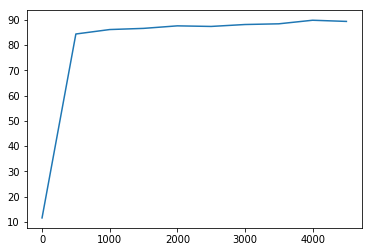

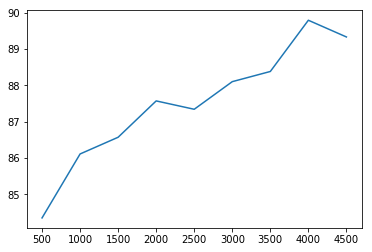

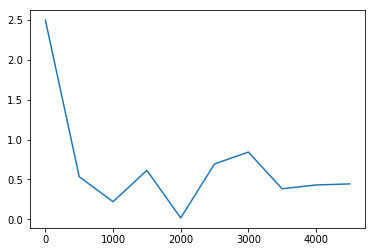

In [ ]:
%%time

num_steps = 5001 #125001
disp_inc = 500

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  track_progress = []
  track_loss = []
  for step in range(num_steps):
    try:
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
      if (step % disp_inc == 0):
        val_pred = valid_prediction.eval()
        valid_acc = accuracy(val_pred, valid_labels)
        track_progress.append(valid_acc)
        track_loss.append(l)
          
        clear_output(wait=True)
      
        print('Minibatch loss at step %d: %f' % (step, l))
        print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
        print('Validation accuracy: %.1f%%' % valid_acc)
        print(np.argmax(val_pred[0:35], 1))
      
        plt.plot([disp_inc * i for i in range(len(track_progress))], track_progress)
        plt.show()
        drop_some = track_progress[(len(track_progress) + 5) // 10:]
        plt.plot([disp_inc * i for i in range(len(track_progress) - len(drop_some), len(track_progress))], drop_some)
        plt.show()
        plt.plot([disp_inc * i for i in range(len(track_loss))], track_loss)
        plt.show()
        
    except KeyboardInterrupt:
      print('Stopped early because KeyboardInterrupt')
      break

  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
  last_bit = track_progress[-30:]
  plt.plot([disp_inc * i for i in range(len(track_progress) - len(last_bit), len(track_progress))], last_bit)
  plt.show()
  last_bit = track_progress[(len(track_progress) + 5) // 10:]
  plt.plot([disp_inc * i for i in range(len(track_progress) - len(last_bit), len(track_progress))], last_bit)
  plt.show()